# Question 2 Part (c)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# sklearn imports
from sklearn.ensemble import RandomForestRegressor, GradientBoostingClassifier
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.model_selection import GridSearchCV, PredefinedSplit

# surpress warnings
from warnings import simplefilter
from sklearn.exceptions import ConvergenceWarning
simplefilter("ignore", category=[ConvergenceWarning])

In [2]:
# Import data into a pandas data frame
wine_df = pd.read_csv('winequality-white.csv', delimiter=';')
wine_df.head() # first few rows

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6


In [3]:
# Split into training, validation, and test
X = wine_df.drop(columns = 'quality')
y = wine_df['quality']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=1/3)

split_index = [-1]*len(X_train) + [0]*len(X_val)
X_pds = np.concatenate((X_train, X_val), axis=0)
y_pds = np.concatenate((y_train, y_val), axis=0)
pds = PredefinedSplit(test_fold = split_index)

### MODEL 1: Random Forest Regressor

In [4]:
rf=RandomForestRegressor(random_state=1024)

# Grid Search

param_grid = { 
    'n_estimators': [100, 200, 400],
    'max_features': [None, 'sqrt', 'log2'],
    'max_depth' : [None, 4, 8, 12, 16],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 5, 10]
}

CV_rf = GridSearchCV(estimator=rf, cv=pds, param_grid=param_grid, verbose=2)
CV_rf.fit(X_pds, y_pds)

Fitting 1 folds for each of 540 candidates, totalling 540 fits
[CV] END max_depth=None, max_features=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   1.5s
[CV] END max_depth=None, max_features=None, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   3.1s
[CV] END max_depth=None, max_features=None, min_samples_leaf=1, min_samples_split=2, n_estimators=400; total time=   6.1s
[CV] END max_depth=None, max_features=None, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   1.5s
[CV] END max_depth=None, max_features=None, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time=   3.0s
[CV] END max_depth=None, max_features=None, min_samples_leaf=1, min_samples_split=5, n_estimators=400; total time=   6.0s
[CV] END max_depth=None, max_features=None, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time=   1.4s
[CV] END max_depth=None, max_features=None, min_samples_leaf=1, min_samples_split=

GridSearchCV(cv=PredefinedSplit(test_fold=array([-1, -1, ...,  0,  0])),
             estimator=RandomForestRegressor(random_state=1024),
             param_grid={'max_depth': [None, 4, 8, 12, 16],
                         'max_features': [None, 'sqrt', 'log2'],
                         'min_samples_leaf': [1, 2, 5, 10],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [100, 200, 400]},
             verbose=2)

In [5]:
CV_rf.best_params_

{'max_depth': None,
 'max_features': 'sqrt',
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 400}

In [6]:
# Fit the model on the train set using the best parameters
rfr = RandomForestRegressor(n_estimators = 400, 
                            max_depth = None, 
                            max_features = 'sqrt',
                            min_samples_leaf = 1,
                            min_samples_split = 2,
                            criterion = 'squared_error')
rfr.fit(X_train, y_train)

RandomForestRegressor(max_features='sqrt', n_estimators=400)

In [7]:
# Evaluate the model
rfr_preds = rfr.predict(X_test)
rfr_errors = abs(rfr_preds - y_test)


def evaluate(model, X_test, y_test):
    predictions = model.predict(X_test)
    errors = abs(predictions - y_test)
    mape = 100 * np.mean(errors / y_test)
    accuracy = 100 - mape
    print('Model Performance')
    print('Average Error: {:0.4f} degrees.'.format(np.mean(errors)))
    print('Accuracy = {:0.2f}%.'.format(accuracy))
    
    return accuracy

print('Mean Squared Error (MSE):', metrics.mean_squared_error(y_test, rfr_preds))
print('Mean Absolute Percentage Error (MAPE):', metrics.mean_absolute_percentage_error(y_test, rfr_preds))

Mean Squared Error (MSE): 0.4079663647959184
Mean Absolute Percentage Error (MAPE): 0.08066332402008422


### MODEL 2: MLP Regressor

In [8]:
nn=MLPRegressor(random_state=1024)

# Grid Search
param_grid = {
    'hidden_layer_sizes': [(50,), (100,), (200,), (50, 50), (100, 100)],
    'alpha': [0.0001, 0.001, 0.05],
    'learning_rate': ['constant','adaptive'],
    'max_iter': [200, 500, 1000, 2000, 4000],
    'early_stopping': [False, True],
    'shuffle': [False, True],
}

CV_nn = GridSearchCV(estimator=nn, cv=pds, param_grid=param_grid, verbose=2)
CV_nn.fit(X_pds, y_pds)

Fitting 1 folds for each of 600 candidates, totalling 600 fits
[CV] END alpha=0.0001, early_stopping=False, hidden_layer_sizes=(50,), learning_rate=constant, max_iter=200, shuffle=False; total time=   1.2s
[CV] END alpha=0.0001, early_stopping=False, hidden_layer_sizes=(50,), learning_rate=constant, max_iter=200, shuffle=True; total time=   0.8s
[CV] END alpha=0.0001, early_stopping=False, hidden_layer_sizes=(50,), learning_rate=constant, max_iter=500, shuffle=False; total time=   0.8s
[CV] END alpha=0.0001, early_stopping=False, hidden_layer_sizes=(50,), learning_rate=constant, max_iter=500, shuffle=True; total time=   0.8s
[CV] END alpha=0.0001, early_stopping=False, hidden_layer_sizes=(50,), learning_rate=constant, max_iter=1000, shuffle=False; total time=   0.7s
[CV] END alpha=0.0001, early_stopping=False, hidden_layer_sizes=(50,), learning_rate=constant, max_iter=1000, shuffle=True; total time=   0.7s
[CV] END alpha=0.0001, early_stopping=False, hidden_layer_sizes=(50,), learning_

GridSearchCV(cv=PredefinedSplit(test_fold=array([-1, -1, ...,  0,  0])),
             estimator=MLPRegressor(random_state=1024),
             param_grid={'alpha': [0.0001, 0.001, 0.05],
                         'early_stopping': [False, True],
                         'hidden_layer_sizes': [(50,), (100,), (200,), (50, 50),
                                                (100, 100)],
                         'learning_rate': ['constant', 'adaptive'],
                         'max_iter': [200, 500, 1000, 2000, 4000],
                         'shuffle': [False, True]},
             verbose=2)

In [9]:
CV_nn.best_params_

{'alpha': 0.05,
 'early_stopping': True,
 'hidden_layer_sizes': (100,),
 'learning_rate': 'constant',
 'max_iter': 200,
 'shuffle': True}

In [10]:
# Fit the model on the train set using the best parameters
nn = MLPRegressor(alpha = 0.05,
                   hidden_layer_sizes = (100,),
                   learning_rate = 'constant',
                   max_iter = 200,
                   shuffle = True)
nn.fit(X_train, y_train)

MLPRegressor(alpha=0.05)

In [11]:
# Evaluate the model
nn_preds = nn.predict(X_test)
nn_trains = nn.predict(X_train)
nn_errors = abs(nn_preds - y_test)

print('Mean Squared Error (MSE):', metrics.mean_squared_error(y_test, nn_preds))
print('Mean Absolute Percentage Error (MAPE):', metrics.mean_absolute_percentage_error(y_test, nn_preds))

Mean Squared Error (MSE): 0.602585569566627
Mean Absolute Percentage Error (MAPE): 0.10611219961189601


### Exploring the relationship between the empirical risk on the validation set and on the test set.

In [12]:
print('For the Random Forest Regressor:')
print('Test Set Mean Squared Error (MSE):', metrics.mean_squared_error(y_test, rfr_preds))
print('Validation Set Mean Squared Error (MSE):', metrics.mean_squared_error(y_val, rfr.predict(X_val)))
# print('Training Set Mean Squared Error (MSE):', metrics.mean_squared_error(y_train, nn.predict(X_train)))

print('For the MLP Regressor:')
print('Test Set Mean Squared Error (MSE):', metrics.mean_squared_error(y_test, nn_preds))
print('Validation Set Mean Squared Error (MSE):', metrics.mean_squared_error(y_val, nn.predict(X_val)))
# print('Training Set Mean Squared Error (MSE):', metrics.mean_squared_error(y_train, nn.predict(X_train)))

For the Random Forest Regressor:
Test Set Mean Squared Error (MSE): 0.4079663647959184
Validation Set Mean Squared Error (MSE): 0.3718853826530612
For the MLP Regressor:
Test Set Mean Squared Error (MSE): 0.602585569566627
Validation Set Mean Squared Error (MSE): 0.5700022046191692


It is apparent that with a large enough hyperparameter set (i.e. size of hyper parameter space > # points on validation set), then the risk on the training and the validation sets is low, however the test risk is comparatively higher.

# Question 3 
## Part (a)

In [13]:
# Import data into a pandas data frame
dset0_df = pd.read_csv('dset0.csv', header=None)
dset0_df.head() # first few rows

,0,1,2,3,4,5
0,1.0,1.332,4.439,-0.487,-0.873,7.0
1,1.0,0.715,4.382,-2.142,3.567,-10.0
2,0.0,-1.545,3.921,-2.139,1.540,-2.0
3,0.0,-0.008,2.427,-0.824,0.552,7.0
4,1.0,0.621,4.275,-0.816,-0.620,-4.0


In [14]:
# Split into training and test
X = dset0_df.drop(columns = 0)
y = dset0_df[0]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=2)

In [15]:
# Fit models with varying numbers of trees and observe the scores
n_trees = [1, 10, 100, 300, 1000]
train_scores = []
test_scores = []

for n in n_trees:
    clf = GradientBoostingClassifier(n_estimators = n, random_state=2)
    clf.fit(X_train, y_train)
    train_scores.append(clf.score(X_train, y_train))
    test_scores.append(clf.score(X_test, y_test))

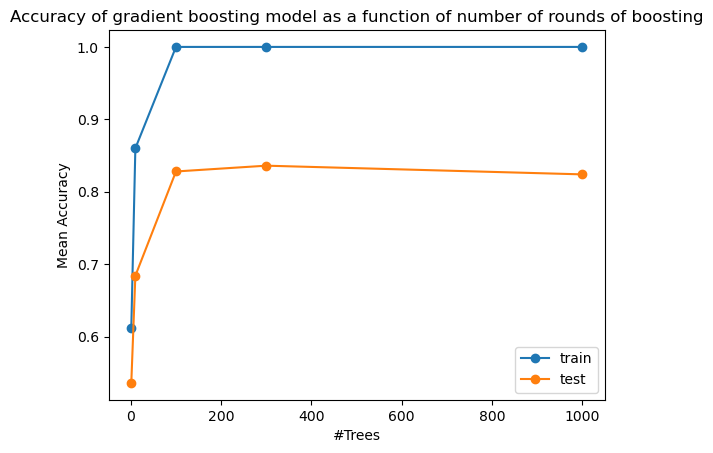

In [16]:
# Generalization behavior
plt.plot(n_trees, train_scores, marker='o', label="train")
plt.plot(n_trees, test_scores, marker='o', label="test")
plt.title("Accuracy of gradient boosting model as a function of number of rounds of boosting")
plt.xlabel("#Trees")
plt.ylabel("Mean Accuracy")
plt.legend()
plt.show()

It seems that these models generalize well, with this particular dataset, as the test accuracy keeps decreasing with further rounds of boosting.

## Part (b)

In [17]:
# Import data into a pandas data frame
dset1_df = pd.read_csv('dset1.csv', header=None)
dset1_df.head() # first few rows

,0,1,2,3,4,5
0,0.0,1.558,4.151,-2.741,-0.368,-4.0
1,1.0,-2.179,5.395,-2.018,-4.662,8.0
2,0.0,0.841,3.552,-1.664,3.957,-9.0
3,0.0,0.438,2.388,-0.383,-2.309,3.0
4,1.0,-0.457,2.534,-1.893,-0.634,4.0


In [18]:
# Split into training and test
X = dset1_df.drop(columns = 0)
y = dset1_df[0]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=2)

In [19]:
# Fit models with varying numbers of trees and observe the scores
n_trees = [1, 10, 100, 300, 1000]
train_scores = []
test_scores = []

for n in n_trees:
    clf = GradientBoostingClassifier(n_estimators = n, random_state=2)
    clf.fit(X_train, y_train)
    train_scores.append(clf.score(X_train, y_train))
    test_scores.append(clf.score(X_test, y_test))

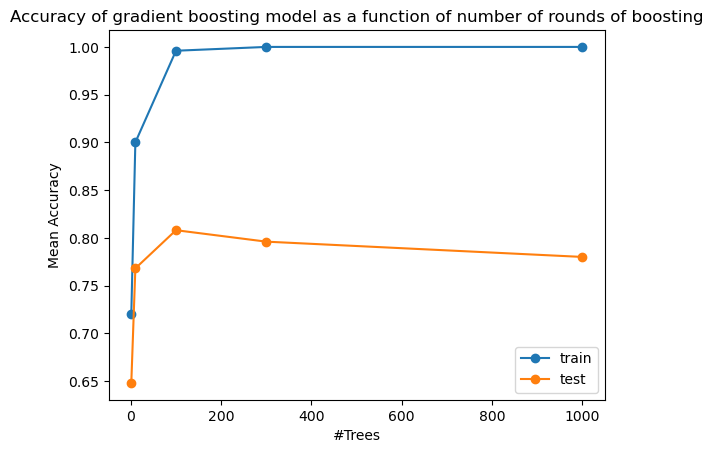

In [20]:
# Generalization behavior
plt.plot(n_trees, train_scores, marker='o', label="train")
plt.plot(n_trees, test_scores, marker='o', label="test")
plt.title("Accuracy of gradient boosting model as a function of number of rounds of boosting")
plt.xlabel("#Trees")
plt.ylabel("Mean Accuracy")
plt.legend()
plt.show()

It seems that these models do not generalize well with the second dataset dataset as compared to the first one, as the test accuracy is not strictly increasing, but actually indecreases with further rounds of boosting.

## Part (c)

In part a) we observe that the test accuracy keeps increasing as we increase the number of rounds of boosting,
however in part b) the test accuracy actually decreases with further rounds of boosting (as noticed from n=300 to n=1000).

Overfitting could be occuring in the second dataset when we use very flexible models.  
As discussed in class, this may be because the second dataset has a small margin, and therefore might not generalize well.